# Feature Engineering


*   The fourth project is the development of a notebook (code + explanation) that successfully engineers 12 unique types of features, **three** for each type of feature engineering: **transforming**, **interacting**, **mapping**, and **extracting**.
* The second part of the assignment is the development of a **deep learning classification** model to predict the direction of the S&P500 for the dates **2018-01-01—2018-07-12** (test set).
* The feature engineering section is unrelated to the model section, you can develop any features, not just features that would work for deep learning models (later on you can decide which features to use in your model).
*  You also have to uncomment all the example features and make them run successfully  → **every** feature example has some error/s that you have to fix. Please also describe the error you fixed!
*   Note that we *won't* be attempting to measure the quality of every feature (i.e., how much it improves the model), that is slightly too advanced for this course.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

Preparing the Data

In [ ]:
# preparing our data
raw_prices = pd.read_csv("https://storage.googleapis.com/sovai-public/random/assetalloc.csv", sep=';', parse_dates=True, index_col='Dates', dayfirst=True)
df = raw_prices.sort_values(by='Dates')
df["target"] = df["SP500"].pct_change().shift(-1)
df["target"] = np.where(df["target"]>0,1,0)
df.head()

,FTSE,EuroStoxx50,SP500,Gold,French-2Y,French-5Y,French-10Y,French-30Y,US-2Y,US-5Y,US-10Y,US-30Y,Russel2000,EuroStox_Small,FTSE_Small,MSCI_EM,CRB,target
Dates,,,,,,,,,,,,,,,,,,
1989-02-01,2039.7,875.47,297.09,392.50,99.081,99.039,99.572,100.000,100.031,100.345,101.080,101.936,154.38,117.50,1636.57,133.584,286.67,0
1989-02-02,2043.4,878.08,296.84,392.00,98.898,99.117,99.278,99.692,100.000,100.314,101.017,101.905,154.94,117.69,1642.94,135.052,287.03,1
1989-02-03,2069.9,884.09,296.97,388.75,98.907,99.002,99.145,99.178,99.812,100.062,100.921,101.718,155.69,118.62,1659.11,137.134,285.63,0
1989-02-06,2044.3,885.49,296.04,388.00,98.484,98.502,98.510,97.739,99.812,100.062,100.794,101.468,155.58,118.89,1656.86,137.037,284.69,1
1989-02-07,2072.8,883.82,299.63,392.75,98.438,98.312,98.292,97.688,99.906,100.251,101.144,102.092,156.84,118.28,1662.76,136.914,284.21,0


###Removing the SP500 column: Possible Custom Addition

We already have built up the target column; we no longer need the SP500 prices.

Although, since the target has been shifted, keeping the original column of today's information won't leak future data when predicting tomorrow's trend. It may hold some information with regard to the future direction of the S&P500

In [ ]:
# df.drop(['SP500'], inplace=True,axis=1)

###Checking dataset: Custom Addition

Let us just ensure that the data is clean and uniform; it may trouble us in the later stages if it isn't

In [ ]:
def validate_data(df):
    """
    Checks the dataframe for any null values, negative prices, or duplicates.

    Parameters:
        df (pd.DataFrame): Dataframe containing price data.

    Returns:
        dict: A dictionary containing the validation results.
    """
    issues = {
        'has_nulls': df.isnull().any().any(),  # Check for any null values in the dataframe
        'has_negatives': (df < 0).any().any(),  # Check for any negative values in the dataframe
        'has_duplicates': df.duplicated().any()  # Check for any duplicates in the dataframe
    }
    return issues

validation_results = validate_data(df)
print(validation_results)

{'has_nulls': False, 'has_negatives': False, 'has_duplicates': True}


In [ ]:
# there are a total of 3 duplicates
df.duplicated().sum()

3

In [ ]:
# we need to get rid of the duplicate
initial_count = len(df)
print(initial_count)
df.drop_duplicates(inplace=True)
final_count = len(df)
print(final_count)

7682
7679


In [ ]:
# all cleaned up
validation_results = validate_data(df)
print(validation_results)

{'has_nulls': False, 'has_negatives': False, 'has_duplicates': False}


We have now removed the duplicates and have done a very high level data cleaning; let us now go onto the main part of the assignement

###Creating a returns dataframe: Custom Addition; trasnforming the whole df

We have seen that many times leveraging ML algorithms on a time series of returns works better than the actual prices. From this point on, let us maintain two dataframes: (1) df {given} (2) dfret {the log returns of the assets in df}.

We will first experiement with and model on the basis of the dfret; and if time permits we can also use the same set of feature engineering approaches to the price df.

In [ ]:
def calculate_log_returns(df):
    """
    Calculates the log returns for each column in the dataframe except 'target',
    which is copied as is.

    Parameters:
        df (pd.DataFrame): DataFrame containing columns of prices.

    Returns:
        pd.DataFrame: DataFrame containing log returns of the prices.
    """
    # Create a new dataframe for the returns
    returns_df = pd.DataFrame()

    # Loop over each column in the dataframe
    for column in df.columns:
        if column != 'target':  # Compute log returns for all columns except 'target'
            # Calculate log return: log(price_t/price_t-1) = log(price_t) - log(price_t-1)
            returns_df[column + '_log_return'] = np.log1p(df[column] / df[column].shift(1) - 1)
        else:
            # Copy the 'target' column as is
            returns_df['target'] = df['target']

    # drop the first row as it will have NaN values due to diff() operation
    returns_df.dropna(inplace=True)

    return returns_df

dfret = calculate_log_returns(df)
dfret.head()

,FTSE_log_return,EuroStoxx50_log_return,SP500_log_return,Gold_log_return,French-2Y_log_return,French-5Y_log_return,French-10Y_log_return,French-30Y_log_return,US-2Y_log_return,US-5Y_log_return,US-10Y_log_return,US-30Y_log_return,Russel2000_log_return,EuroStox_Small_log_return,FTSE_Small_log_return,MSCI_EM_log_return,CRB_log_return,target
Dates,,,,,,,,,,,,,,,,,,
1989-02-02,0.001812,0.002977,-0.000842,-0.001275,-0.001849,0.000787,-0.002957,-0.003085,-0.000310,-0.000309,-0.000623,-0.000304,0.003621,0.001616,0.003885,0.010929,0.001255,1
1989-02-03,0.012885,0.006821,0.000438,-0.008325,0.000091,-0.001161,-0.001341,-0.005169,-0.001882,-0.002515,-0.000951,-0.001837,0.004829,0.007871,0.009794,0.015299,-0.004889,0
1989-02-06,-0.012445,0.001582,-0.003137,-0.001931,-0.004286,-0.005063,-0.006425,-0.014616,0.000000,0.000000,-0.001259,-0.002461,-0.000707,0.002274,-0.001357,-0.000708,-0.003296,1
1989-02-07,0.013845,-0.001888,0.012054,0.012168,-0.000467,-0.001931,-0.002215,-0.000522,0.000941,0.001887,0.003466,0.006131,0.008066,-0.005144,0.003555,-0.000898,-0.001687,0
1989-02-08,0.011226,0.009000,-0.003276,-0.005745,0.001218,0.003513,0.004710,0.002096,-0.000941,-0.000948,-0.001266,-0.004290,0.001020,0.003797,0.011416,0.000825,0.000598,0


In [ ]:
# let us check the size of the dfret; one less row; we are all set now
print(df.shape)
print(dfret.shape)

(7679, 18)
(7678, 18)


In [ ]:
saved = df.copy()

### Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split
y = df.pop("target")
X = df.copy()

X_train = X[X.index.astype(str)<'2018-01-01']
y_train = y[X_train.index]
X_test = X[~X.index.isin(X_train.index)]
y_test = y[X_test.index]

X_train_untouched = X_train
y_train_untouched = y_train
X_test_untouched = X_test
y_test_untouched = y_test

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

###Train Test Split for the dfret

In [ ]:
y_ret = dfret.pop("target")
X_ret = dfret.copy()

X_train_ret = X_ret[X_ret.index.astype(str)<'2018-01-01']
y_train_ret = y_ret[X_train_ret.index]
X_test_ret = X_ret[~X_ret.index.isin(X_train_ret.index)]
y_test_ret = y_ret[X_test_ret.index]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

### Transforming

1. Refresh your mind on tranformation methods by going back to the material. I am simply providing 1 example here.
1. Don't repeat my logarithmic return calculation, develop your own transformation (there are 1000s of types of transformations).
1. In the example I provide, there is also an error that you have to fix. For example, one of the errors below is that you should actually use `np.log1p()`, but there is another one, so watch out!

In [ ]:
# Example Transforming (has errors)

# Name: Logarithmic return of FTSE
# Description: Developing the logarithmic return feature for use within linear models that make normality assumptions.

# correction1: log -> log1p
# correction2: need log returns ... not log prices; misleading column name as well
df["FTSE_log_return"] = np.log1p(df["FTSE"] / df["FTSE"].shift(1) - 1)

Let us now apply three very commonly used transformations on the dataframe.



In [ ]:
## Transforming 1

# Name: Log returns
# Description: computing log returns for all the asset prices from the df; the rationale being:
# (1) we usually work with log returns and not the prices themselves in finance
# (2) we want the dataset to atleast look close to normal to satisfy normality constraints of linear models

Let us see the difference it makes in terms of how close normal the time series are, when we use the unscaled asset prices v/s the log returns

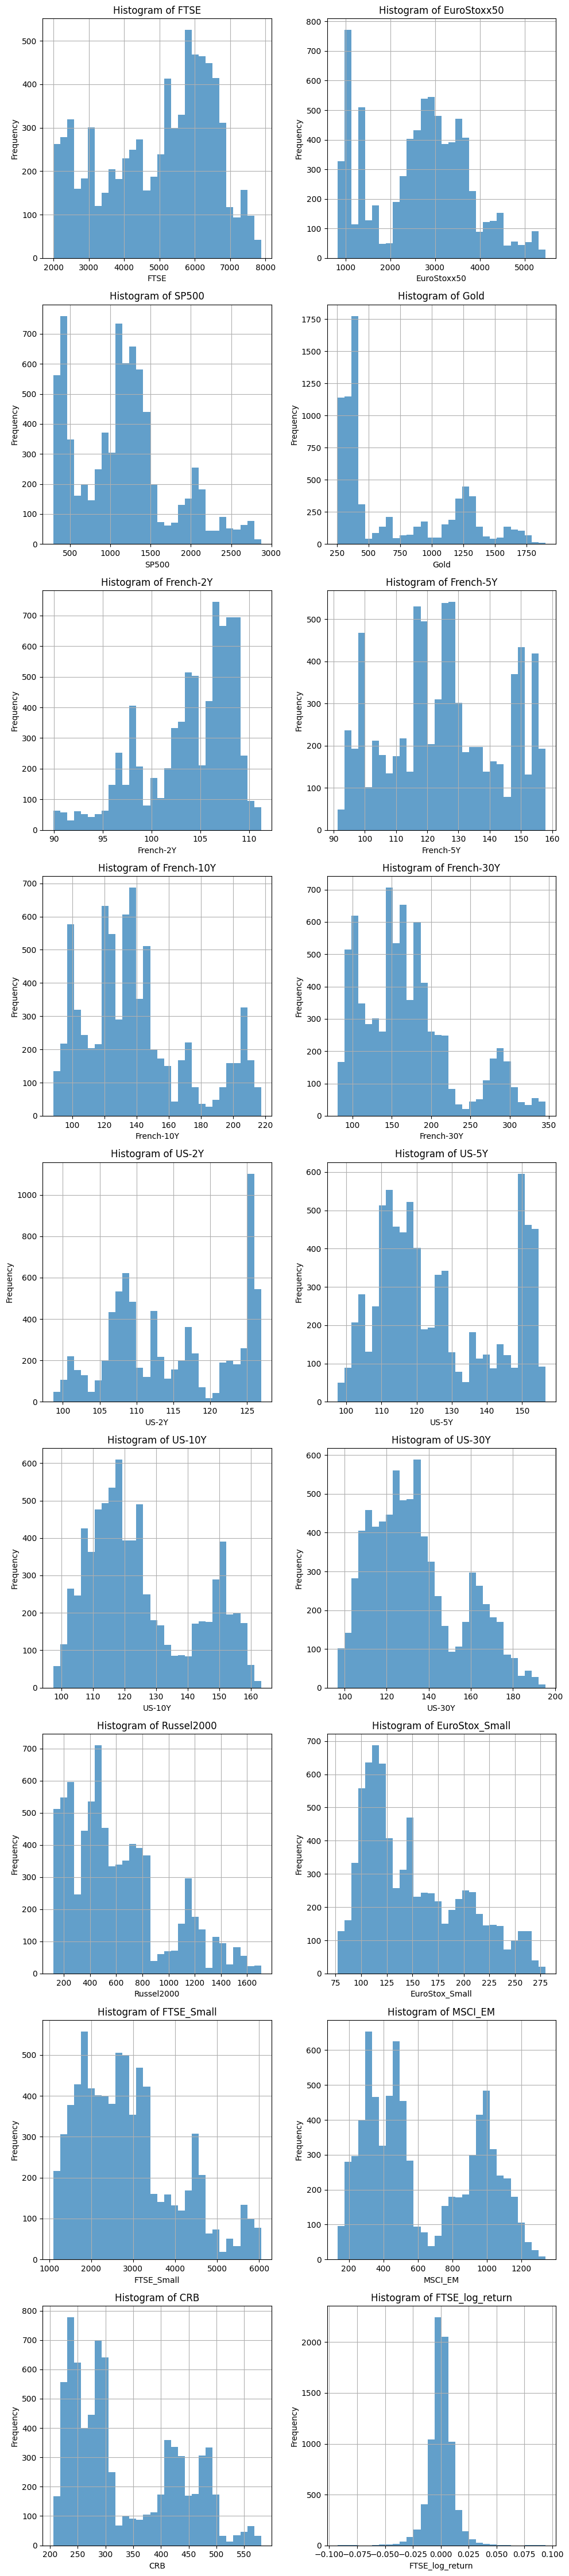

In [ ]:
import matplotlib.pyplot as plt

def plot_histograms_and_visualize_normality(df):
    """
    Plots histograms for all columns in the dataframe except the 'target' column.

    Parameters:
        df (pd.DataFrame): The dataframe to analyze.
    """
    columns_to_analyze = [col for col in df.columns if col != 'target']

    # Setting up the plot
    n_cols = len(columns_to_analyze)
    n_rows = (n_cols + 1) // 2
    plt.figure(figsize=(10, 5 * n_rows))

    for i, column in enumerate(columns_to_analyze, 1):
        plt.subplot(n_rows, 2, i)
        # Plot histogram
        df[column].hist(bins=30, alpha=0.7)
        plt.title(f'Histogram of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# let us see the graphs of unscaled prices ... don't remotely look normal in most cases
plot_histograms_and_visualize_normality(df)

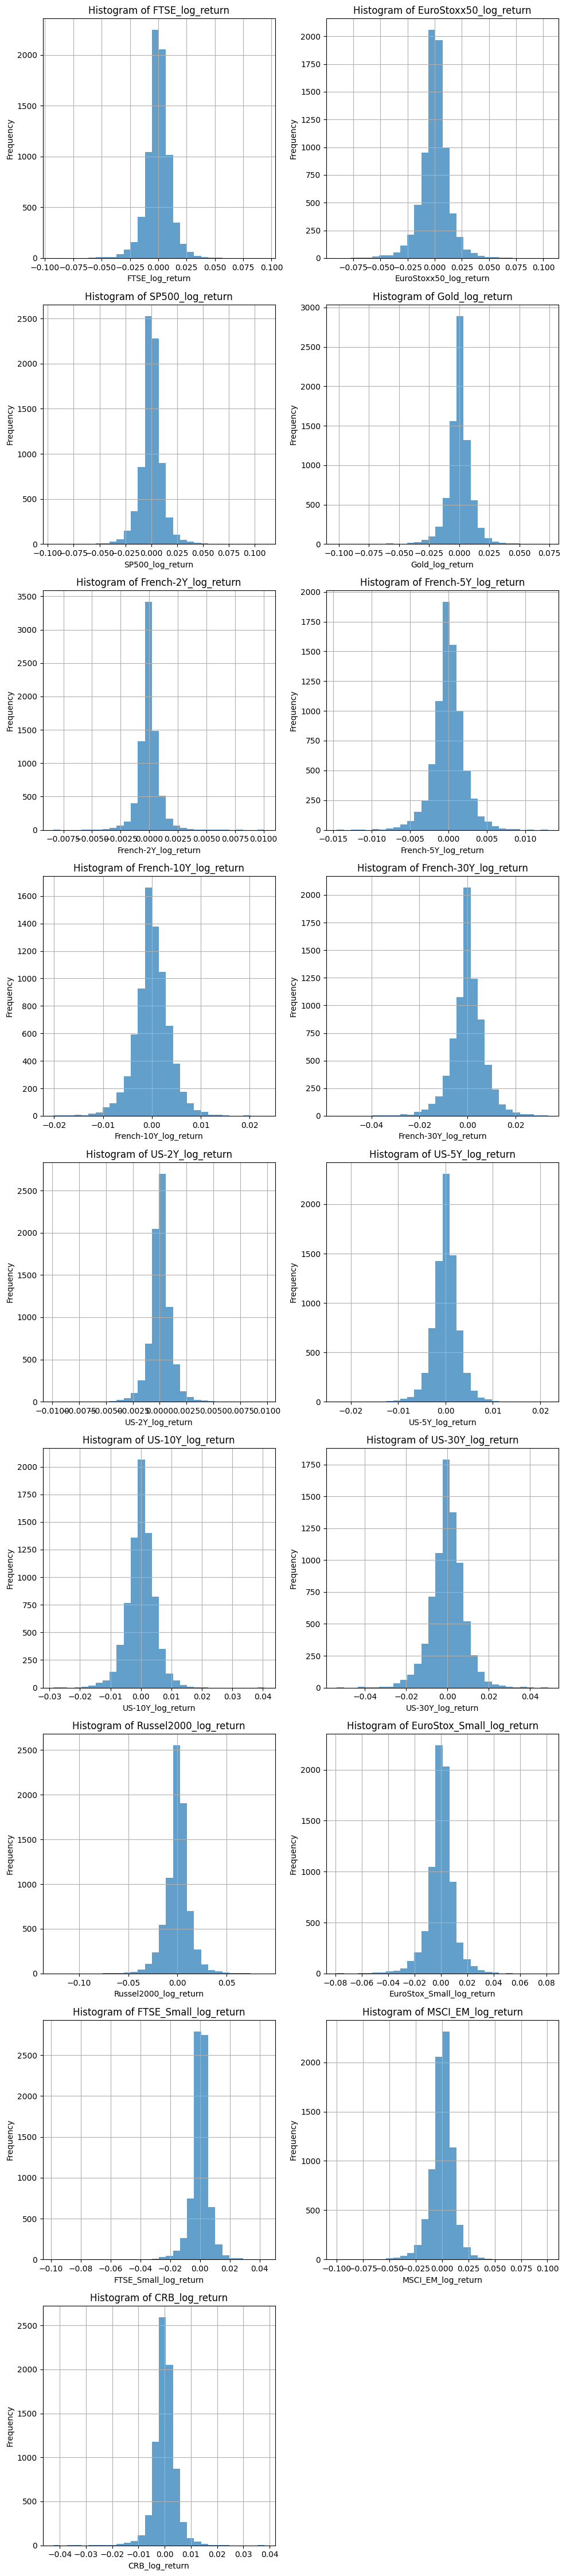

In [ ]:
# let us see the graphs of log returns ... much more normal
plot_histograms_and_visualize_normality(dfret)

We can see that the log returns are closer to normal than the unscaled prices

In [ ]:
## Transforming 2

# Name: Standardization of the returns
# Description: we want all the features to be more or less in the same range
# Also gradient descent and distance based algorithms do not work well with unscaled data;
# thus, we need to scale the data appropriately for us to get good results in the modelling section of the project
# and ANNs assume that inputs are roughly standardized

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train_ret = pd.DataFrame(scaler.fit_transform(X_train_ret), columns=X_train_ret.columns, index=X_train_ret.index)

# Use the same scaler to transform the test data
X_test_ret = pd.DataFrame(scaler.transform(X_test_ret), columns=X_test_ret.columns, index=X_test_ret.index)

In [ ]:
X_train_ret.head()

,FTSE_log_return,EuroStoxx50_log_return,SP500_log_return,Gold_log_return,French-2Y_log_return,French-5Y_log_return,French-10Y_log_return,French-30Y_log_return,US-2Y_log_return,US-5Y_log_return,US-10Y_log_return,US-30Y_log_return,Russel2000_log_return,EuroStox_Small_log_return,FTSE_Small_log_return,MSCI_EM_log_return,CRB_log_return
Dates,,,,,,,,,,,,,,,,,
1989-02-02,0.152053,0.212556,-0.104682,-0.146911,-2.092218,0.360402,-0.850546,-0.466292,-0.334278,-0.135734,-0.150594,-0.046870,0.261901,0.146585,0.579240,0.941705,0.293722
1989-02-03,1.180960,0.505138,0.013524,-0.869291,0.115173,-0.597826,-0.400532,-0.767620,-1.885371,-0.966952,-0.223613,-0.238571,0.357310,0.754954,1.500764,1.328308,-1.209657
1989-02-06,-1.172750,0.106423,-0.316643,-0.214165,-4.865836,-2.517197,-1.816132,-2.133172,-0.028413,-0.019325,-0.292414,-0.316633,-0.079885,0.210567,-0.238196,-0.087961,-0.819877
1989-02-07,1.270138,-0.157671,1.086492,1.230359,-0.520056,-0.976478,-0.644091,-0.095814,0.900503,0.691618,0.761767,0.758057,0.612977,-0.510837,0.527762,-0.104807,-0.426218
1989-02-08,1.026768,0.670939,-0.329531,-0.604949,1.398062,1.701195,1.283808,0.282678,-0.957329,-0.376510,-0.294003,-0.545393,0.056463,0.358758,1.753632,0.047645,0.132963


In [ ]:
X_test_ret.head()

,FTSE_log_return,EuroStoxx50_log_return,SP500_log_return,Gold_log_return,French-2Y_log_return,French-5Y_log_return,French-10Y_log_return,French-30Y_log_return,US-2Y_log_return,US-5Y_log_return,US-10Y_log_return,US-30Y_log_return,Russel2000_log_return,EuroStox_Small_log_return,FTSE_Small_log_return,MSCI_EM_log_return,CRB_log_return
Dates,,,,,,,,,,,,,,,,,
2018-01-01,-0.016354,-0.014001,-0.026920,-0.016311,0.011615,-0.033403,-0.144760,-0.020363,-0.028413,-0.019325,-0.011514,-0.008824,-0.024065,-0.010553,-0.026567,-0.094809,-0.013343
2018-01-02,-0.497084,-0.313831,0.736898,0.738629,-0.062814,-0.501162,-0.770483,-1.049692,-0.639997,-0.729007,-1.074395,-1.756991,0.718231,0.285232,-0.397888,1.522913,1.048017
2018-01-03,0.262789,0.414261,0.562257,0.229953,0.098448,-0.016931,0.435387,0.446050,-0.187328,0.098196,0.378848,0.661967,0.106776,0.496493,0.708087,0.441896,0.436907
2018-01-04,0.283206,1.254744,0.344461,0.109709,-0.497074,-0.389465,0.229112,1.131164,-0.489411,-0.433369,-0.154066,-0.088111,0.135501,1.067716,0.568899,0.595687,0.873474
2018-01-05,0.325200,0.807875,0.620519,0.098683,-0.112490,0.207285,-0.158175,-0.379231,-0.187428,-0.316081,-0.472808,-0.601060,0.193421,0.721860,0.685683,0.599389,-0.074979


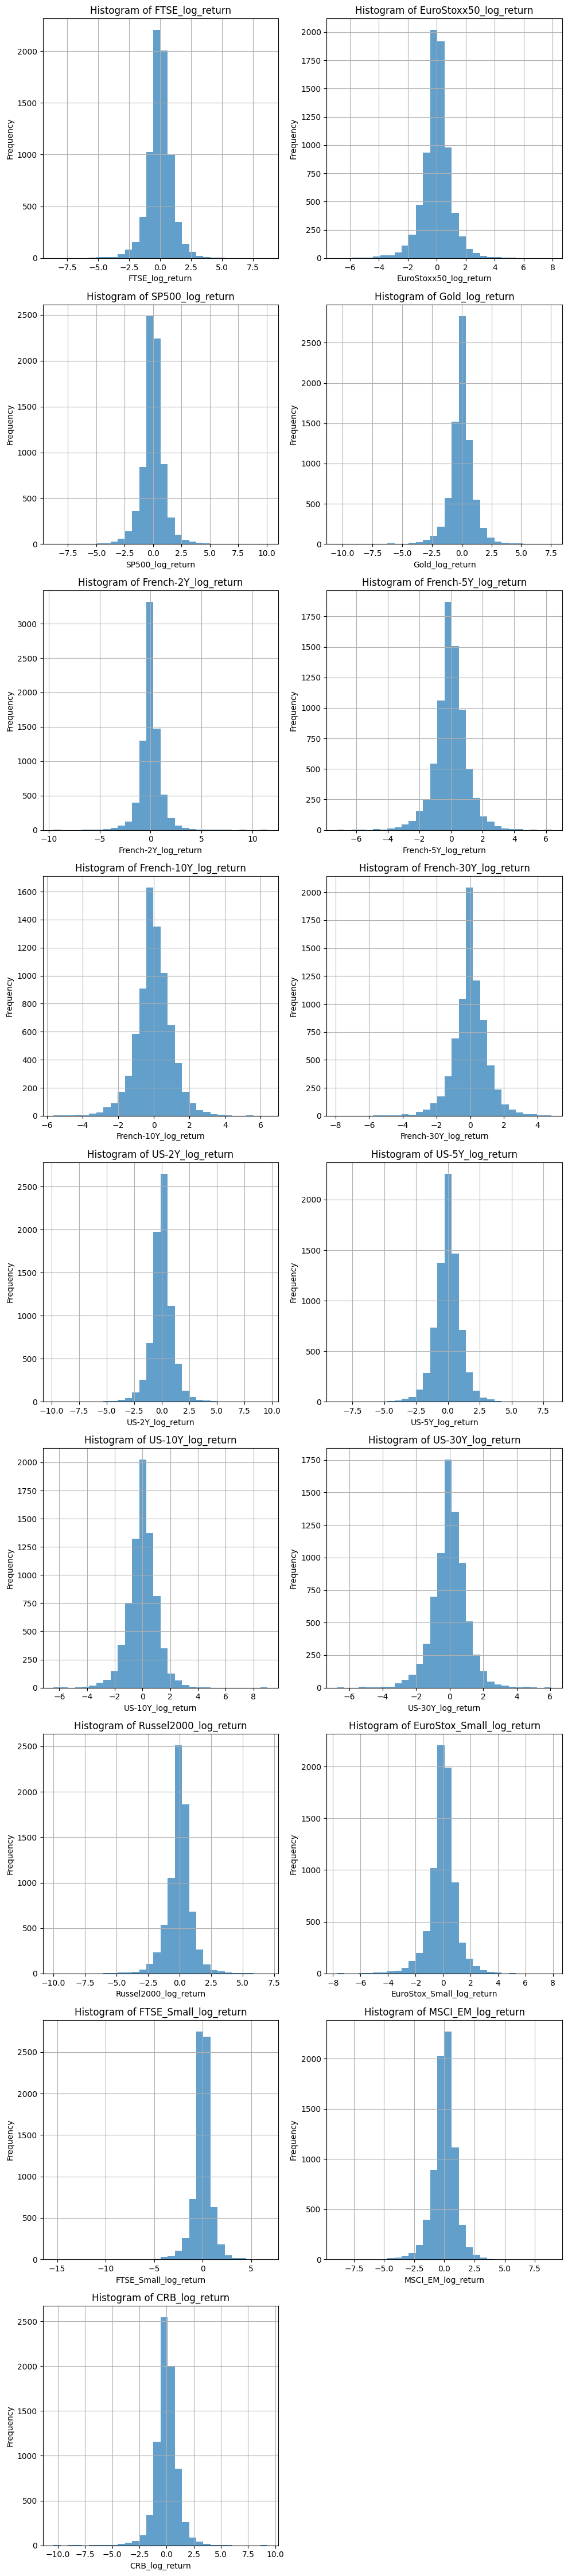

In [ ]:
# let us visualize the difference;
# we can see that the ranges are much closer to the normal distribution now
plot_histograms_and_visualize_normality(X_train_ret)

In [ ]:
## Transforming 3

# Name: Box-Cox trasnformation
# Description:  In the Box-Cox transformation, lambda (λ) is a parameter that controls the type
# of transformation applied to our data. It can take on values typically between roughly -5 and 5
# Transformation:
# λ = 0: Logarithmic transformation (log(data))
# 0 < λ < 1: Fractional power transformation ((data^(λ) - 1) / λ)
# λ = 1: No transformation (data)
# λ > 1: Power transformation you provided (λ * (data^(λ) - 1))


# Advantages of the Box Cox trasnformation:
# * Normality: Asset prices often exhibit skewed distributions or non-constant variance (heteroscedasticity).
# The Box-Cox transformation aims to create a more normal distribution.
#
# * Homoscedasticity: asset prices can have heteroscedasticity, meaning the variance of errors
# (differences between actual values and predicted values) is not constant across the data.
# The Box-Cox transformation can help achieve homoscedasticity, improving the reliability of statistical inferences.
#
# * Linearity: Box-Cox transformation can sometimes make relationships between variables more linear.

from scipy.stats import boxcox

def apply_box_cox_transformation(df):
    """
    Applies the Box-Cox transformation to all columns in the dataframe that contain only positive values.
    Columns with non-positive values are skipped.

    Parameters:
        df (pd.DataFrame): The dataframe with asset prices.

    Returns:
        pd.DataFrame: A dataframe with transformed values where applicable.
    """
    df_transformed = pd.DataFrame(index=df.index)
    for column in df.columns:
        # Check if all values in the column are greater than zero
        if (df[column] > 0).all() and column!='target':
            # Apply Box-Cox transformation
            transformed_data, _ = boxcox(df[column])
            df_transformed[column] = transformed_data
        else:
            # Log a message or handle columns with non-positive values differently
            print(f"Skipping column {column} because it contains non-positive values.")
            df_transformed[column] = df[column]  # Optionally copy the original data

    return df_transformed

In [ ]:
df_box_cox = apply_box_cox_transformation(df)

Skipping column FTSE_log_return because it contains non-positive values.


In [ ]:
df_box_cox['target'] = saved['target']

In [ ]:
df_box_cox.dropna(inplace=True)
df_box_cox.head()

,FTSE,EuroStoxx50,SP500,Gold,French-2Y,French-5Y,French-10Y,French-30Y,US-2Y,US-5Y,US-10Y,US-30Y,Russel2000,EuroStox_Small,FTSE_Small,MSCI_EM,CRB,FTSE_log_return,target
Dates,,,,,,,,,,,,,,,,,,,
1989-02-02,24123.535801,303.525373,24.943187,1.508322,2.540257e+20,32.486936,1.489143,3.002080,4.289280,0.737517,0.548663,1.021727,8.129971,1.817342,7.306997,10.017752,1.131907,0.001812,1
1989-02-03,24551.483777,305.220940,24.948363,1.508149,2.542741e+20,32.459975,1.489070,3.000030,4.287650,0.737512,0.548663,1.021706,8.141730,1.818069,7.316535,10.073493,1.131873,0.012885,0
1989-02-06,24138.036856,305.615604,24.911304,1.508108,2.428310e+20,32.342637,1.488723,2.994221,4.287650,0.737512,0.548663,1.021678,8.140008,1.818278,7.315213,10.070910,1.131850,-0.012445,1
1989-02-07,24598.437679,305.144812,25.054000,1.508361,2.416152e+20,32.298000,1.488603,2.994013,4.288465,0.737515,0.548663,1.021748,8.159670,1.817804,7.318675,10.067633,1.131838,0.013845,0
1989-02-08,24978.181956,307.395787,25.015143,1.508242,2.447985e+20,32.379267,1.488858,2.994848,4.287650,0.737514,0.548663,1.021699,8.162158,1.818154,7.329791,10.070644,1.131842,0.011226,0


Additional Note: More complex procedures such as the Rolling Basis Technqiue can be implemented.

### Interacting

There are millions of possible interaction methods, be creative and come up with your own. For this assignment there is no 'right' feature engineering method, you simply develop one, and give it a name and a discreption.

In [ ]:
# Example Interacting (has errors)

# Name: Ratio of Gold return to 10Y treasury
# Desciption: Both gold and treasuries are safe-haven assets and descrepency in their ratio could be a sign of some marco-economic event.

## conceptual error: (1) it uses the raw prices for gold returns rather than the percentage change; also, it should
# handle the (2) edge case of when the teny_returns are 0.0000

## incorrect code:
# def gold_to_yield(df):
#   teny_returns = df["US-10Y"].pct_change()
#   gold_returns = df["Gold"]
#   df["gold_r__div__teny_r"] = gold_returns/teny_returns
#   return df

# X_train = gold_to_yield(X_train); X_test = gold_to_yield(X_test)

# corrected version:
def gold_to_yield(df):
    # Calculate percentage changes (returns) for both gold and the 10-year Treasury
    df.loc[:, 'teny_returns'] = df["US-10Y"].pct_change()
    df.loc[:, 'gold_returns'] = df["Gold"].pct_change()  # Corrected to also use percentage change

    # Avoid division by zero by replacing zero returns with a small number
    df.loc[:, 'teny_returns'].replace(0, np.finfo(float).eps, inplace=True)

    df.loc[:, 'gold_r__div__teny_r'] = df.loc[:, 'gold_returns'] / df.loc[:, 'teny_returns']

    # Cleanup the intermediate columns
    df.drop(columns=['teny_returns', 'gold_returns'], inplace=True)
    return df

In [ ]:
# Apply the function to train and test datasets
X_train = gold_to_yield(X_train.copy())
X_test = gold_to_yield(X_test.copy())

In [ ]:
## Interacting 1

# Name: Cross-Market Volatility Indicator
# Description:
# Standard deviation of returns across several major indices (FTSE, EuroStoxx50, Russel2000, MSCI_EM).
#
# Rationale:
# This indicator measures cross-market volatility, reflecting global economic stability or distress.
# Higher volatility across these indices could forewarn of negative movements in the S&P 500
# due to increased uncertainty or risk aversion globally.

def add_cross_market_volatility_indicator(df):
    df['cross_market_volatility'] = df[['FTSE_log_return', 'EuroStoxx50_log_return', 'Russel2000_log_return', 'MSCI_EM_log_return']].std(axis=1)
    return df

In [ ]:
## Interacting 2
# Name: Commodities Influence on Industrial Activity
# Description:
# Interaction between commodity prices (CRB Index) and industrial equities (Russel2000).
# Product of CRB log returns and Russel2000 log returns.
#
# Rationale:
# Commodities prices often lead industrial activity. An increase in both commodity prices and
# industrial stocks could signal strong economic activity and confidence, potentially lifting
# the broader market including the S&P 500.

def add_commodities_influence_on_industry(df):
    df['commodity_industry_interaction'] = df['CRB_log_return'] * df['Russel2000_log_return']
    return df

In [ ]:
## Interacting 3
# Name:  Interest Rate Expectation Metric
# Descirption:
# Differential movement between short-term and long-term U.S. Treasury yields.
#  Difference between US-2Y and US-30Y log returns.
#
# Rationale:
# This difference serves as a proxy for the yield curve slope.
# A steepening curve (rising short-term yields faster than long-term) often suggests
# increasing interest rate expectations and economic optimism, potentially boosting the S&P 500.

def add_interest_rate_expectation_metric(df):
    df['interest_rate_expectation'] = df['US-2Y_log_return'] - df['US-30Y_log_return']
    return df

In [ ]:
## Interacting 4
# Name:  Global Risk Appetite Indicator
# Descirption:
# Ratio of returns between a global equity index (FTSE or EuroStoxx50) and a safe-haven asset (Gold).
# Ratio of the sum of standardized log returns of FTSE and EuroStoxx50 to Gold log returns.
#
# Rationale:
# This ratio can act as an indicator of global risk appetite.
# An increasing ratio suggests a preference for equities over gold, indicating bullish
# market sentiments, which could positively influence the S&P 500.

def add_global_risk_appetite_indicator(df):
    # Compute the sum of returns for global indices
    df['global_equity_returns'] = df['Russel2000_log_return'] + df['FTSE_log_return'] + df['EuroStoxx50_log_return']
    # Compute the ratio to Gold returns
    df['global_risk_appetite'] = df['global_equity_returns'] / df['Gold_log_return'].replace(0, np.finfo(float).eps)
    return df

In [ ]:
# Creating and adding the features
X_train_ret = add_global_risk_appetite_indicator(X_train_ret)
X_train_ret = add_interest_rate_expectation_metric(X_train_ret)
X_train_ret = add_commodities_influence_on_industry(X_train_ret)
X_train_ret = add_cross_market_volatility_indicator(X_train_ret)

X_test_ret = add_global_risk_appetite_indicator(X_test_ret)
X_test_ret = add_interest_rate_expectation_metric(X_test_ret)
X_test_ret = add_commodities_influence_on_industry(X_test_ret)
X_test_ret = add_cross_market_volatility_indicator(X_test_ret)

In [ ]:
# sanity check
X_train_ret.isnull().sum().sum()

0

In [ ]:
# sanity check
X_test_ret.isnull().sum().sum()

0

In [ ]:
print(X_train_ret.shape)
print(X_test_ret.shape)
print(y_train_ret.shape)
print(y_test_ret.shape)

(7539, 22)
(139, 22)
(7539,)
(139,)


### Mapping

This one is slightly harder, you have to identify other  dimensionality reduction methods, there are many more than just PCA. Maybe you can also look at performing the decompositions just on a single asset classes, e.g., US-2Y, US-5Y, US-10Y, US-30Y is a fixed income asset class, but there are a few others in the dataset.

In [ ]:
# Example Mapping (has errors)

# Name: First prinicipal component of all of the assets returns
# Description:For stocks the first component resmbles the return of the market, for multiple asset classes it could resemble a 'universal' asset class


# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler

# def pca_first(X_train, X_test):
#   sc = StandardScaler()
#   X_train_s = sc.fit_transform(X_train.fillna(0))
#   X_test_s = sc.transform(X_test.fillna(0))

#   pca = PCA(1)
#   X_train["first_prinicipal"] = pca.fit_transform(X_train_s.fillna(0))
#   X_test["first_prinicipal"] = pca.transform(X_test_s.fillna(0))
#   return X_train, X_test

# X_train, X_test = pca_first(X_train, X_test)

# # ValueError: Input contains infinity or a value too large for dtype('float64').

# mistake:
# - The function redundantly calls fillna(0) the second time
# - The error message about infinity or large values typically occurs because of extreme values
# or scale issues in the data. The use of StandardScaler should handle this

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

def pca_first(X_train, X_test):
    # Create a copy to avoid changing the original data
    X_train = X_train.copy()
    X_test = X_test.copy()

    # Handle inf/nan values by replacing them with NaN and then imputing with the mean of each column
    X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Fill NaN values with the mean of each column in the training data
    for column in X_train.columns:
        mean_value = X_train[column].mean()
        X_train[column].fillna(mean_value, inplace=True)
        X_test[column].fillna(mean_value, inplace=True)

    # Standardize the data
    sc = StandardScaler()
    X_train_s = sc.fit_transform(X_train)
    X_test_s = sc.transform(X_test)

    # Initialize PCA with one component
    pca = PCA(n_components=1)

    # Transform the data using PCA and add as a new column
    X_train['first_principal'] = pca.fit_transform(X_train_s)
    X_test['first_principal'] = pca.transform(X_test_s)

    return X_train, X_test

X_train, X_test = pca_first(X_train, X_test)

In [ ]:
## Mapping 1

# >>> Autoecoding approach for (1) Dimentionality Reduction and (2) de-noising
# Using ANNs to compress and regenerate data; giving us denoised data and [1,..,n] compoenents

from sklearn.preprocessing import StandardScaler
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
import pandas as pd

def autoencoder_dimensionality_reduction(X_train, X_test, n_components):
    # Define the size of the encoded representation
    encoding_dim = n_components

    # Input placeholder
    input_data = Input(shape=(X_train.shape[1],))
    # "encoded" is the encoded representation of the input
    encoded = Dense(encoding_dim, activation='relu')(input_data)
    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(X_train.shape[1], activation='sigmoid')(encoded)

    # This model maps an input to its reconstruction
    autoencoder = Model(input_data, decoded)

    # This model maps an input to its encoded representation
    encoder = Model(input_data, encoded)

    # Compile the autoencoder
    autoencoder.compile(optimizer=Adam(), loss='mean_squared_error')

    # Train the autoencoder using the scaled data
    autoencoder.fit(X_train, X_train,
                    epochs=50,
                    batch_size=256,
                    shuffle=True,
                    validation_data=(X_test, X_test))

    # Use the encoder to transform the training and test sets
    X_train_encoded = encoder.predict(X_train)
    X_test_encoded = encoder.predict(X_test)

    # Convert numpy arrays back to pandas DataFrame
    X_train_encoded = pd.DataFrame(X_train_encoded, index=X_train.index)
    X_test_encoded = pd.DataFrame(X_test_encoded, index=X_test.index)

    return X_train_encoded, X_test_encoded

In [ ]:
n_components = 5  # reducing down to 5 dimentions
X_train_encoded, X_test_encoded = autoencoder_dimensionality_reduction(X_train_ret, X_test_ret, n_components)
X_train_encoded.head()

Epoch 1/50
30/30 [==============================] - 1s 21ms/step - loss: 25587.6250 - val_loss: 18.2299
Epoch 2/50
30/30 [==============================] - 0s 3ms/step - loss: 25587.5684 - val_loss: 18.1847
Epoch 3/50
30/30 [==============================] - 0s 3ms/step - loss: 25587.5137 - val_loss: 18.1390
Epoch 4/50
30/30 [==============================] - 0s 3ms/step - loss: 25587.4629 - val_loss: 18.0898
Epoch 5/50
30/30 [==============================] - 0s 4ms/step - loss: 25587.4023 - val_loss: 18.0304
Epoch 6/50
30/30 [==============================] - 0s 3ms/step - loss: 25586.8652 - val_loss: 17.9322
Epoch 7/50
30/30 [==============================] - 0s 3ms/step - loss: 25585.6680 - val_loss: 17.8795
Epoch 8/50
30/30 [==============================] - 0s 3ms/step - loss: 25585.6172 - val_loss: 17.8445
Epoch 9/50
30/30 [==============================] - 0s 3ms/step - loss: 25585.5840 - val_loss: 17.8180
Epoch 10/50
30/30 [==============================] - 0s 3ms/step - loss:

,0,1,2,3,4
Dates,,,,,
1989-02-02,5.334052,3.871458,2.422175,0.0,0.000000
1989-02-03,8.900676,0.000000,1.346593,0.0,0.265326
1989-02-06,0.438184,0.000000,12.577378,0.0,0.000000
1989-02-07,0.902377,0.083372,0.841163,0.0,0.000000
1989-02-08,4.778118,0.943229,0.000000,0.0,1.549791


In [ ]:
## Mapping 2

# >>> PCA Dimentionality reduction
# we are splitting the price data into (1) equites (2) fixed income (3) commodities
# we then take the first principal component for each of these groups and finally end up with a
# a dataframe with 3 columns of compresses information of the three asset classes

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd

def apply_grouped_pca(X_train_ret, X_test_ret):
    # Defining asset groups
    equity_columns = ['FTSE_log_return', 'EuroStoxx50_log_return', 'Russel2000_log_return',
                      'EuroStox_Small_log_return', 'FTSE_Small_log_return', 'MSCI_EM_log_return']
    commodity_columns = ['Gold_log_return', 'CRB_log_return']
    fixed_income_columns = ['French-2Y_log_return', 'French-5Y_log_return', 'French-10Y_log_return',
                            'French-30Y_log_return', 'US-2Y_log_return', 'US-5Y_log_return',
                            'US-10Y_log_return', 'US-30Y_log_return']

    # Helper function to apply PCA to a specific group
    def pca_for_group(df_train, df_test, columns):
        scaler = StandardScaler()
        pca = PCA(n_components=1)

        # Scaling and PCA fitting on train data
        scaled_train = scaler.fit_transform(df_train[columns])
        pca_train = pca.fit_transform(scaled_train)

        # Applying the same transformation to the test data
        scaled_test = scaler.transform(df_test[columns])
        pca_test = pca.transform(scaled_test)

        return pca_train, pca_test

    # Initialize empty DataFrames for PCA results
    X_train_pca = pd.DataFrame(index=X_train_ret.index)
    X_test_pca = pd.DataFrame(index=X_test_ret.index)

    # Apply PCA to each group and store results in the new dataframes
    X_train_pca['equity_pc1'], X_test_pca['equity_pc1'] = pca_for_group(X_train_ret, X_test_ret, equity_columns)
    X_train_pca['commodity_pc1'], X_test_pca['commodity_pc1'] = pca_for_group(X_train_ret, X_test_ret, commodity_columns)
    X_train_pca['fixed_income_pc1'], X_test_pca['fixed_income_pc1'] = pca_for_group(X_train_ret, X_test_ret, fixed_income_columns)

    return X_train_pca, X_test_pca

In [ ]:
X_train_ret_PCA3, X_test_ret_PCA3 = apply_grouped_pca(X_train_ret, X_test_ret)

In [ ]:
## Mapping 3

# Independent Componenet Analysis
# Independent Component Analysis (ICA) is a method for separating a complex dataset into underlying,
# statistically independent components. It aims to find hidden factors or sources that
# contribute to the data, assuming these factors are not just uncorrelated but truly independent.

from sklearn.decomposition import FastICA
from sklearn.preprocessing import StandardScaler
import pandas as pd

def apply_ica(X_train_ret, X_test_ret, n_components):
    # Initialize the StandardScaler
    scaler = StandardScaler()

    # this step may be redundant in our case
    # but we want to be sure that our data is normalized
    # Fit and transform the training data
    X_train_scaled = scaler.fit_transform(X_train_ret)
    # Transform the test data with the same scaler
    X_test_scaled = scaler.transform(X_test_ret)

    # Initialize the ICA model
    ica = FastICA(n_components=n_components, random_state=0)

    # Fit and transform the ICA model on the scaled training data
    X_train_ica = ica.fit_transform(X_train_scaled)
    # Transform the test data using the fitted ICA model
    X_test_ica = ica.transform(X_test_scaled)

    # Convert the numpy arrays back to pandas DataFrame
    X_train_ica = pd.DataFrame(X_train_ica, columns=[f'IC_{i+1}' for i in range(n_components)], index=X_train_ret.index)
    X_test_ica = pd.DataFrame(X_test_ica, columns=[f'IC_{i+1}' for i in range(n_components)], index=X_test_ret.index)

    return X_train_ica, X_test_ica

In [ ]:
n_components = 5  # Set to the number of independent components we want to extract
X_train_ica, X_test_ica = apply_ica(X_train_ret, X_test_ret, n_components)
X_train_ica.head()

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


,IC_1,IC_2,IC_3,IC_4,IC_5
Dates,,,,,
1989-02-02,0.009163,-0.008748,-0.003234,0.002970,-0.003114
1989-02-03,0.004606,-0.001590,-0.016983,0.012788,-0.014238
1989-02-06,0.001932,-0.040344,0.000364,-0.000611,-0.002524
1989-02-07,0.001506,-0.009541,0.011826,0.002332,-0.007978
1989-02-08,0.004694,0.020231,-0.007958,0.000685,-0.002984


In [ ]:
X_train_ret.isnull().sum().sum()

0

###Extracting

In [ ]:
# Example Extracting (has errors)
# Name: Annualized volatility in returns
# Description: We are developing an annualized volatility measure for all asset returns, which is a good measure of market turbulence

# mistake: Changed the rolling window to 252 days, reflecting the typical number of trading days in a year for more accurate annualization.

import pandas as pd

def vola(df):
    # Calculate daily volatility and then annualize it
    volatility = df.pct_change().rolling(window=252).std() * (252 ** 0.5)  # Using 252 trading days for annualization
    # Rename the columns appropriately
    new_names = {i: f'{i}_annual_vol' for i in df.columns}
    volatility.rename(columns=new_names, inplace=True)
    # Concatenate the new features to the original dataframe
    df = pd.concat([df, volatility], axis=1)
    return df

# X_train = vola(X_train)
# X_test = vola(X_test)

In [ ]:
## Extracting 1

# Name:  Cross-Index Momentum Indicators
# Description: Indices such as the FTSE, EuroStoxx50, and Russell 2000 can reflect broader
# market sentiments and economic conditions that also affect the S&P 500

def add_cross_index_momentum(df, columns, short_window=12, long_window=26):
    for col in columns:
        short_ema = df[col].ewm(span=short_window, adjust=False).mean()
        long_ema = df[col].ewm(span=long_window, adjust=False).mean()
        df[f'{col}_macd'] = short_ema - long_ema
    return df

columns = ['FTSE_log_return', 'EuroStoxx50_log_return', 'Russel2000_log_return']
X_train_ret_cross_idx = add_cross_index_momentum(X_train_ret, columns)
X_test_ret_cross_idx = add_cross_index_momentum(X_test_ret, columns)

In [ ]:
## Extracting 2

# Name: Rolling Statistical Features
# Description:
# Statistical measures such as variance, skewness, and kurtosis over rolling windows
# can help detect changes in the distribution of returns, indicative of increased market risk or potential turning points.
# Changes in the distribution characteristics of asset returns can indicate shifts in market volatility and investor sentiment.

def add_rolling_stats(df, window=22):  # 1 month of trading days
    for col in df.columns:
        df[f'{col}_rolling_std'] = df[col].rolling(window=window).std() * (252 ** 0.5)  # Annualized
        df[f'{col}_rolling_skew'] = df[col].rolling(window=window).skew()
        df[f'{col}_rolling_kurt'] = df[col].rolling(window=window).kurt()
    return df

# X_train_ret_rollingStats = add_rolling_stats(X_train_ret)
# X_test_ret_rollingStats = add_rolling_stats(X_test_ret)

In [ ]:
## Extracting 3

# Name: Lagged Returns as Predictive Signals
# Description:
# Incorporating lagged returns of various global indices and commodities as features to capture
# the temporal dependencies that may influence the S&P 500.
# Market behaviors are often interrelated globally; movements in international
# markets and commodities might precede similar movements in the U.S. market.

def add_lagged_returns(df, lags=[1, 5, 22]):
    # Initialize a dictionary to hold new columns
    new_cols = {}

    for col in df.columns:
        for lag in lags:
            new_col_name = f'{col}_lag_{lag}'
            # Store the lagged series in the dictionary
            new_cols[new_col_name] = df[col].shift(lag)

    # Convert the dictionary into a DataFrame
    new_cols_df = pd.DataFrame(new_cols, index=df.index)

    # Concatenate the new columns with the original DataFrame
    df = pd.concat([df, new_cols_df], axis=1)

    return df

# X_train_ret_lagged = add_lagged_returns(X_train_ret)
# X_test_ret_lagged = add_lagged_returns(X_test_ret)

In [ ]:
X_train_ret.isnull().sum().sum()

0

###Checking for NaNs and data inconsistencies

Before we jump to modelling let us check the data consistency



In [ ]:
X_train_ret.isnull().sum().sum()

0

In [ ]:
X_test_ret.isnull().sum().sum()

0

In [ ]:
X_train_ret.shape

(7539, 25)

In [ ]:
X_test_ret.shape

(139, 25)

In [ ]:
y_train_ret.shape

(7539,)

In [ ]:
X_train_ret.columns

Index(['FTSE_log_return', 'EuroStoxx50_log_return', 'SP500_log_return',
       'Gold_log_return', 'French-2Y_log_return', 'French-5Y_log_return',
       'French-10Y_log_return', 'French-30Y_log_return', 'US-2Y_log_return',
       'US-5Y_log_return', 'US-10Y_log_return', 'US-30Y_log_return',
       'Russel2000_log_return', 'EuroStox_Small_log_return',
       'FTSE_Small_log_return', 'MSCI_EM_log_return', 'CRB_log_return',
       'global_equity_returns', 'global_risk_appetite',
       'interest_rate_expectation', 'commodity_industry_interaction',
       'cross_market_volatility', 'FTSE_log_return_macd',
       'EuroStoxx50_log_return_macd', 'Russel2000_log_return_macd'],
      dtype='object')

# Deep Learning Binary Classification

* For the deep learning model you can perform new data preprocessing methods and new feature engineering that are better suited to neural networks. You can also use all or some of the features you developed above (most features work in deep learning models as long as they are normalized).
* It is very hard to predict the stock price, so in my grading I will look more at the quality of the model you process (e.g., that there is no data leakage, that you performed some hyperparameter tuning).
* Make sure that you switch your GPU on, you have access to it on Colab. The training stage also takes long, you might want to use a smaller amount of data, or fewer epochs at first to speed up your development process.
* After your training is done, you don't have to save your model, but you do have to print the performance of your model. You can report two metrics the ROC(AUC) and the Accuracy against the test set.
* Also remember to set the random seed (random state) so that when I run your software, I get similar results (the results doesn't have to be exactely the same).
* You can choose any type of deep learning archetecture, e.g., LSTM, GRU, CNN, it is up to you.
* Remember that this section is less that 25% of the grade, so don't waste your time here.
* And lastly, remember this is the stock market, so it is **difficult** to have an accuracy above 50%, good luck!

In [ ]:
# import numpy as np
# import pandas as pd

# split_ratio = 0.8
# split_index = int(len(X_train_ret) * split_ratio)

# X_train, X_val = X_train_ret.iloc[:split_index, :], X_train_ret.iloc[split_index:, :]
# Y_train, Y_val = y_train_ret.iloc[:split_index], y_train_ret.iloc[split_index:]

# print("Training features shape: ", X_train.shape)
# print("Validation features shape: ", X_val.shape)
# print("Training labels shape: ", y_train.shape)
# print("Validation labels shape: ", Y_val.shape)

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization
from sklearn.metrics import roc_auc_score, accuracy_score
import matplotlib.pyplot as plt

In [ ]:
# Standardizing (new columns added to the dataset) before we give it as input to the model
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Fitting the scaler on the training data and transform it
X_train_ret = pd.DataFrame(scaler.fit_transform(X_train_ret), columns=X_train_ret.columns, index=X_train_ret.index)

# Using the same scaler to transform the test data
X_test_ret = pd.DataFrame(scaler.transform(X_test_ret), columns=X_test_ret.columns, index=X_test_ret.index)

###Expanding window crossvalidation

In [ ]:
# using expading window cross validation
def expanding_window_cv(X, initial_size, horizon, gap):
    """
    Generates train and validation indices with expanding window and a gap.
    """
    end = len(X)
    start = initial_size
    while start + horizon + gap < end:
        train_indices = range(start)
        valid_indices = range(start + gap, start + gap + horizon)
        yield train_indices, valid_indices
        start += horizon + gap


##Simplistic ANNs

Let us try out simplistic ANNs

In [ ]:
from tensorflow.keras.layers import BatchNormalization

# Model 1: Basic Dense Model
def build_model_1(input_dim):
    model = Sequential([
        Dense(64, input_dim=input_dim, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Model 2: Increased Depth
def build_model_2(input_dim):
    model = Sequential([
        Dense(128, input_dim=input_dim, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Model 3: With Batch Normalization
def build_model_3(input_dim):
    model = Sequential([
        Dense(128, input_dim=input_dim, activation='relu'),
        BatchNormalization(),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Model 4: With Dropout
def build_model_4(input_dim):
    model = Sequential([
        Dense(128, input_dim=input_dim, activation='relu'),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
models = [
    ('Model 1', build_model_1(X_train_ret.shape[1])),
    ('Model 2', build_model_2(X_train_ret.shape[1])),
    ('Model 3', build_model_3(X_train_ret.shape[1])),
    # ('LSTM Model', build_lstm_model(timesteps, features)),
    ('Model 4', build_model_4(X_train_ret.shape[1]))
]

results_auc = {name: [] for name, _ in models}
results_acc = {name: [] for name, _ in models}

# Setting the parameters for the expanding window cross-validation
initial_size = int(len(X_train_ret) * 0.1)  # Start with 10% of data as the initial training set
horizon = int(len(X_train_ret) * 0.05)  # Each validation set is 5% of the data
gap = 5  # Skipping 5 rows between the training and validation set to avoid leakage


# performing expanding window crossvalidation
for name, model in models:
    for train_indices, valid_indices in expanding_window_cv(X_train_ret, initial_size, horizon, gap):
        print(name)

        X_train, X_val = X_train_ret.iloc[train_indices], X_train_ret.iloc[valid_indices]
        Y_train, Y_val = y_train_ret.iloc[train_indices], y_train_ret.iloc[valid_indices]

        model.fit(X_train, Y_train, epochs=10, batch_size=32, verbose=0)
        predictions = model.predict(X_val)
        roc_auc = roc_auc_score(Y_val, predictions)
        accuracy = accuracy_score(Y_val, np.round(predictions))

        results_auc[name].append(roc_auc)
        results_acc[name].append(accuracy)

Model 1
12/12 [==============================] - 0s 2ms/step
Model 1
12/12 [==============================] - 0s 2ms/step
Model 1
12/12 [==============================] - 0s 3ms/step
Model 1
12/12 [==============================] - 0s 2ms/step
Model 1
12/12 [==============================] - 0s 2ms/step
Model 1
12/12 [==============================] - 0s 2ms/step
Model 1
12/12 [==============================] - 0s 2ms/step
Model 1
12/12 [==============================] - 0s 3ms/step
Model 1
12/12 [==============================] - 0s 2ms/step
Model 1
12/12 [==============================] - 0s 2ms/step
Model 1
12/12 [==============================] - 0s 2ms/step
Model 1
12/12 [==============================] - 0s 2ms/step
Model 1
12/12 [==============================] - 0s 2ms/step
Model 1
12/12 [==============================] - 0s 2ms/step
Model 1
12/12 [==============================] - 0s 2ms/step
Model 1
12/12 [==============================] - 0s 2ms/step
Model 1
12/12 [=========

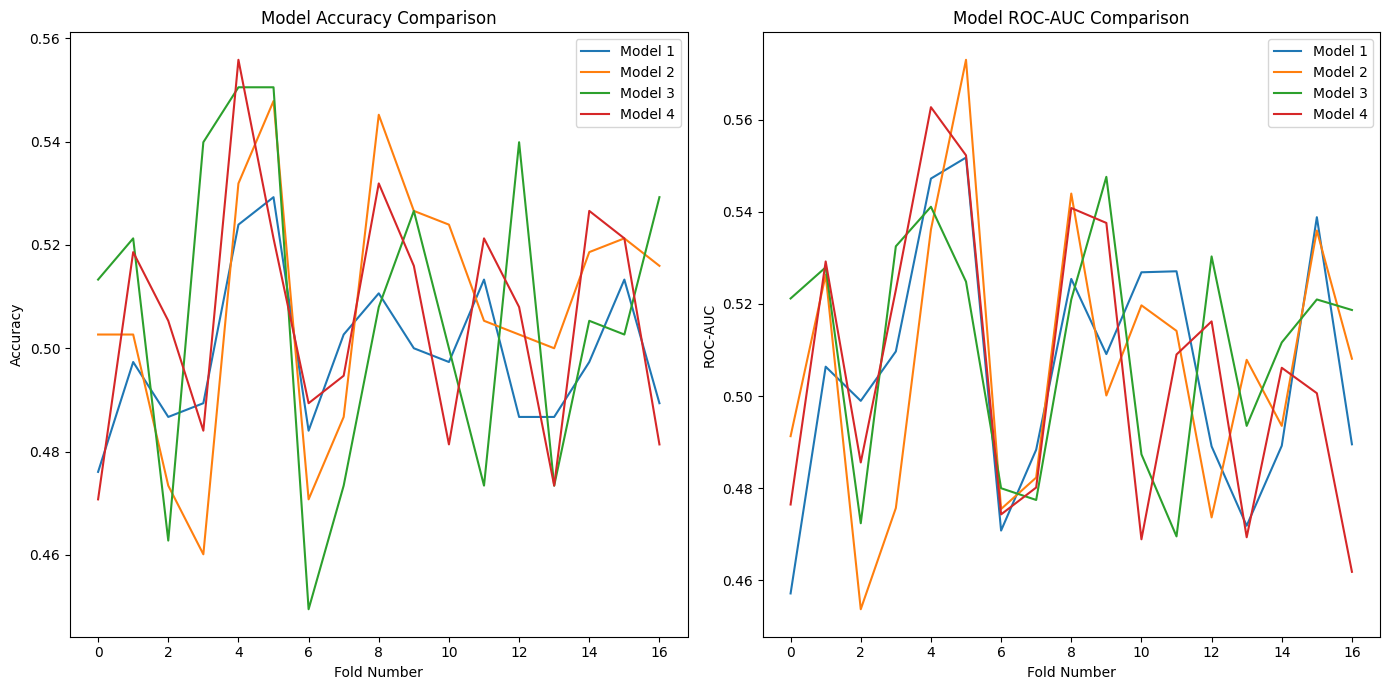

In [ ]:
# Plotting the results of the expanding window cross validation
def plot_auc_acc(results_acc, results_auc):
  plt.figure(figsize=(14, 7))
  plt.subplot(1, 2, 1)
  for name in results_acc:
      plt.plot(results_acc[name], label=name)
  plt.title('Model Accuracy Comparison')
  plt.xlabel('Fold Number')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  for name in results_auc:
      plt.plot(results_auc[name], label=name)
  plt.title('Model ROC-AUC Comparison')
  plt.xlabel('Fold Number')
  plt.ylabel('ROC-AUC')
  plt.legend()

  plt.tight_layout()
  plt.show()

plot_auc_acc(results_acc, results_auc)

##LSTM GRU CNN

Lets expriment with more complex ANN approaches

In [ ]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten


In [ ]:
# Number of features
features = X_train_ret.shape[1]

from tensorflow.keras.layers import Reshape

def build_lstm_model(features):
    model = Sequential([
        Reshape((features, 1), input_shape=(features,)),  # Reshape flat input to [timesteps, features]
        LSTM(50, return_sequences=False),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_gru_model(features):
    model = Sequential([
        Reshape((features, 1), input_shape=(features,)),
        GRU(50, return_sequences=False),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_cnn_model(features):
    model = Sequential([
        Reshape((features, 1), input_shape=(features,)),  # Reshape input for CNN
        Conv1D(32, 3, activation='relu'),
        MaxPooling1D(2),
        Conv1D(64, 3, activation='relu'),
        MaxPooling1D(2),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
models = [
    ('LSTM Model', build_lstm_model(features)),
    ('GRU Model', build_gru_model(features)),
    ('CNN Model', build_cnn_model(features)),
]

results_auc = {name: [] for name, _ in models}
results_acc = {name: [] for name, _ in models}

# Set the parameters for the expanding window cross-validation
initial_size = int(len(X_train_ret) * 0.1)  # Start with 10% of data as the initial training set
horizon = int(len(X_train_ret) * 0.05)  # Each validation set is 5% of the data
gap = 5  # Skip 5 rows between the training and validation set to avoid leakage

for name, model in models:
    for train_indices, valid_indices in expanding_window_cv(X_train_ret, initial_size, horizon, gap):
        print(name)

        X_train, X_val = X_train_ret.iloc[train_indices], X_train_ret.iloc[valid_indices]
        Y_train, Y_val = y_train_ret.iloc[train_indices], y_train_ret.iloc[valid_indices]

        model.fit(X_train, Y_train, epochs=10, batch_size=32, verbose=0)
        predictions = model.predict(X_val)
        roc_auc = roc_auc_score(Y_val, predictions)
        accuracy = accuracy_score(Y_val, np.round(predictions))

        results_auc[name].append(roc_auc)
        results_acc[name].append(accuracy)

LSTM Model
12/12 [==============================] - 1s 6ms/step
LSTM Model
12/12 [==============================] - 0s 7ms/step
LSTM Model
12/12 [==============================] - 0s 9ms/step
LSTM Model
12/12 [==============================] - 0s 5ms/step
LSTM Model
12/12 [==============================] - 0s 5ms/step
LSTM Model
12/12 [==============================] - 0s 7ms/step
LSTM Model
12/12 [==============================] - 0s 6ms/step
LSTM Model
12/12 [==============================] - 0s 6ms/step
LSTM Model
12/12 [==============================] - 0s 8ms/step
LSTM Model
12/12 [==============================] - 0s 7ms/step
LSTM Model
12/12 [==============================] - 0s 6ms/step
LSTM Model
12/12 [==============================] - 0s 5ms/step
LSTM Model
12/12 [==============================] - 0s 5ms/step
LSTM Model
12/12 [==============================] - 0s 6ms/step
LSTM Model
12/12 [==============================] - 0s 11ms/step
LSTM Model
12/12 [=====================

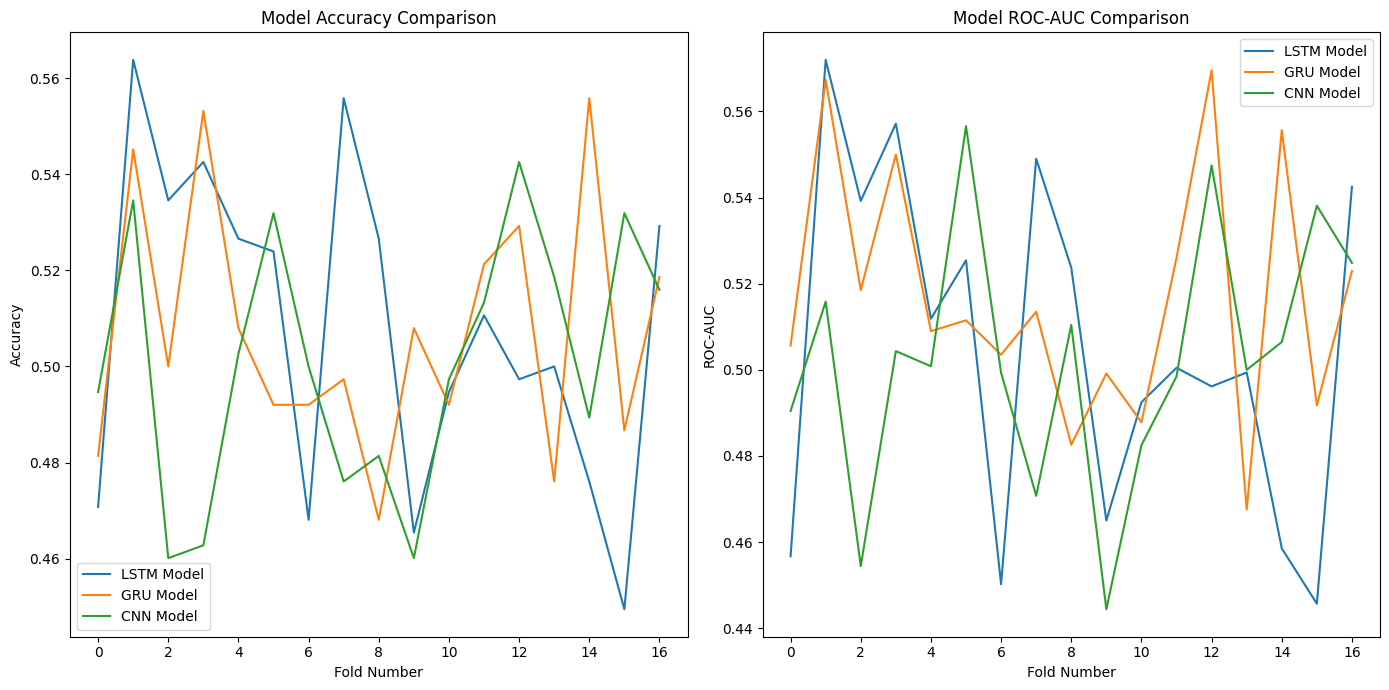

In [ ]:
# accuracy and AUC results from the expanding window crossvalidation
plot_auc_acc(results_acc, results_auc)

In [ ]:
X_train_ret.columns

Index(['FTSE_log_return', 'EuroStoxx50_log_return', 'SP500_log_return',
       'Gold_log_return', 'French-2Y_log_return', 'French-5Y_log_return',
       'French-10Y_log_return', 'French-30Y_log_return', 'US-2Y_log_return',
       'US-5Y_log_return', 'US-10Y_log_return', 'US-30Y_log_return',
       'Russel2000_log_return', 'EuroStox_Small_log_return',
       'FTSE_Small_log_return', 'MSCI_EM_log_return', 'CRB_log_return',
       'global_equity_returns', 'global_risk_appetite',
       'interest_rate_expectation', 'commodity_industry_interaction',
       'cross_market_volatility', 'FTSE_log_return_macd',
       'EuroStoxx50_log_return_macd', 'Russel2000_log_return_macd'],
      dtype='object')

##Hyperparameter tuning

Let us tune the hyperparameters for the LSTM model; we know that number of units following the input layer is usually varied to gauge changes in performance.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Reshape
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_auc_score
import numpy as np

def create_lstm_model(units):
    features = X_train_ret.shape[1]
    model = Sequential([
        Reshape((features, 1), input_shape=(features,)),
        LSTM(units, return_sequences=False),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Parameters to tune
units_options = [5, 10, 20, 30]  # Different number of LSTM units

# Setup to store results
results = {
    'LSTM': {'best_acc': 0, 'best_auc': 0, 'best_acc_params': None, 'best_auc_params': None}
}

# Perform grid search only for LSTM
for units in units_options:
    lstm_scores = []
    lstm_aucs = []
    print(f"Training with units: {units}")

    # Custom expanding window cross-validation
    for train_indices, valid_indices in expanding_window_cv(X_train_ret, int(len(X_train_ret) * 0.3), int(len(X_train_ret) * 0.1), 5):
        X_train, X_val = X_train_ret.iloc[train_indices], X_train_ret.iloc[valid_indices]
        Y_train, Y_val = y_train_ret.iloc[train_indices], y_train_ret.iloc[valid_indices]

        lstm_model = create_lstm_model(units)
        lstm_model.fit(X_train, Y_train, epochs=10, batch_size=32, verbose=0)

        # Evaluate model for accuracy
        _, acc = lstm_model.evaluate(X_val, Y_val, verbose=0)
        lstm_scores.append(acc)

        # Evaluate model for AUC
        probas = lstm_model.predict(X_val)
        auc = roc_auc_score(Y_val, probas)
        lstm_aucs.append(auc)

    # Calculate median of scores
    median_acc = np.median(lstm_scores)
    median_auc = np.median(lstm_aucs)

    print(f"Results for units {units}: Median ACC = {median_acc}, Median AUC = {median_auc}")

    # Update best scores and parameters for accuracy
    if median_acc > results['LSTM']['best_acc']:
        results['LSTM']['best_acc'] = median_acc
        results['LSTM']['best_acc_params'] = {'units': units}

    # Update best scores and parameters for AUC
    if median_auc > results['LSTM']['best_auc']:
        results['LSTM']['best_auc'] = median_auc
        results['LSTM']['best_auc_params'] = {'units': units}

# Output best results for LSTM
print("Best LSTM Model by Accuracy: %f using %s" % (results['LSTM']['best_acc'], results['LSTM']['best_acc_params']))
print("Best LSTM Model by AUC: %f using %s" % (results['LSTM']['best_auc'], results['LSTM']['best_auc_params']))


Training with units: 5
24/24 [==============================] - 1s 3ms/step
Results for units 5: Median ACC = 0.5079681277275085, Median AUC = 0.5171459101599194
Training with units: 10
24/24 [==============================] - 1s 7ms/step
Results for units 10: Median ACC = 0.5033200681209564, Median AUC = 0.5087612959446858
Training with units: 20
24/24 [==============================] - 1s 5ms/step
Results for units 20: Median ACC = 0.5013280212879181, Median AUC = 0.5015843010163387
Training with units: 30
24/24 [==============================] - 1s 4ms/step
Results for units 30: Median ACC = 0.5059761106967926, Median AUC = 0.5133098775495203
Best LSTM Model by Accuracy: 0.507968 using {'units': 5}
Best LSTM Model by AUC: 0.517146 using {'units': 5}


We can also tune for the number of dense notes in the penultimate layer.

We can also tune for the number of lags given as input

Furthermore, me might also want to investigate tuning with respect to the number of epochs of training.

*Overall, more extensive hyperparameter tuning can be conducted if  more computational resourses are avaiable.*

##Tuned Model testing - Lets use the best set of hyperparameters

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Reshape
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

# Define the model creation function with specific units
def create_best_lstm_model(units):
    features = X_train_ret.shape[1]
    model = Sequential([
        Reshape((features, 1), input_shape=(features,)),
        LSTM(units, return_sequences=False),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# The best parameters
best_units = 5

# Initialize the model with all features from the data
model = create_best_lstm_model(best_units)

# Training the model with all data
model.fit(X_train_ret, y_train_ret, epochs=100, batch_size=32, verbose=1)

Epoch 1/100
236/236 [==============================] - 7s 13ms/step - loss: 0.6926 - accuracy: 0.5156
Epoch 2/100
236/236 [==============================] - 3s 14ms/step - loss: 0.6922 - accuracy: 0.5153
Epoch 3/100
236/236 [==============================] - 3s 11ms/step - loss: 0.6920 - accuracy: 0.5185
Epoch 4/100
236/236 [==============================] - 2s 10ms/step - loss: 0.6918 - accuracy: 0.5242
Epoch 5/100
236/236 [==============================] - 3s 12ms/step - loss: 0.6918 - accuracy: 0.5125
Epoch 6/100
236/236 [==============================] - 3s 11ms/step - loss: 0.6917 - accuracy: 0.5200
Epoch 7/100
236/236 [==============================] - 4s 15ms/step - loss: 0.6918 - accuracy: 0.5152
Epoch 8/100
236/236 [==============================] - 3s 12ms/step - loss: 0.6915 - accuracy: 0.5177
Epoch 9/100
236/236 [==============================] - 2s 10ms/step - loss: 0.6916 - accuracy: 0.5156
Epoch 10/100
236/236 [==============================] - 2s 10ms/step - loss: 0.691

In [ ]:
# Prediction on training set
train_predictions_prob = model.predict(X_train_ret)
train_predictions = (train_predictions_prob > 0.5).astype(int)

# Prediction on testing set
test_predictions_prob = model.predict(X_test_ret)
test_predictions = (test_predictions_prob > 0.5).astype(int)

# Calculate accuracy and AUC for training and testing
train_acc = accuracy_score(y_train_ret, train_predictions)
test_acc = accuracy_score(y_test_ret, test_predictions)
train_auc = roc_auc_score(y_train_ret, train_predictions_prob)
test_auc = roc_auc_score(y_test_ret, test_predictions_prob)

print(f"Training Accuracy: {train_acc:.3f}")
print(f"Testing Accuracy: {test_acc:.3f}")
print(f"Training AUC: {train_auc:.3f}")
print(f"Testing AUC: {test_auc:.3f}")

5/5 [==============================] - 0s 4ms/step
Training Accuracy: 0.543
Testing Accuracy: 0.518
Training AUC: 0.563
Testing AUC: 0.521


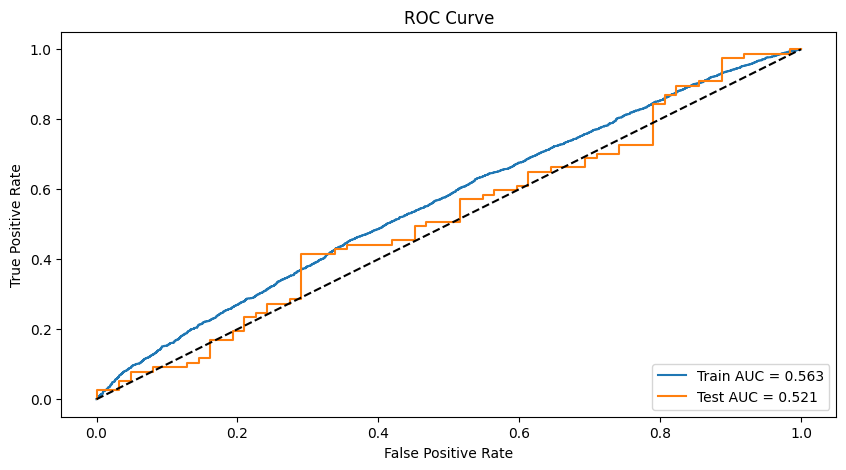

In [ ]:
# Plot ROC curves
fpr_train, tpr_train, _ = roc_curve(y_train_ret, train_predictions_prob)
fpr_test, tpr_test, _ = roc_curve(y_test_ret, test_predictions_prob)

plt.figure(figsize=(10, 5))
plt.plot(fpr_train, tpr_train, label=f"Train AUC = {train_auc:.3f}")
plt.plot(fpr_test, tpr_test, label=f"Test AUC = {test_auc:.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()